In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cellbayesassay as cba
import pickle
from scipy.stats import dunnett, spearmanr
import re
import attila_utils

## Read posterior probabilities

In [2]:
P_CO25360 = pd.read_csv('../../results/2023-09-26-cell-bayes-assays/H102_posteriors.csv', index_col=[0, 1], header=[0, 1])
P_CO25360 = P_CO25360.rename({'TUDCA': 'TI21', 'Cysteamine': 'TI22', 'Arundine': 'TI26'}, axis=1, level=0)
P_CO25360['study'] = 'CO25360'
P_CO25360 = P_CO25360.set_index('study', append=True)
P_CO25360 = P_CO25360.swaplevel(1,2).swaplevel(0, 1).stack(level=0)
P_CO25360

H1  \
study                                                                       
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI21  0.99275   
                                                            TI22  0.00000   
                                                            TI26  0.87900   
                                                    Aβ42 SN TI21  0.09825   
                                                            TI22  0.00200   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI26  0.05100   
                                                    YOPRO   TI21  0.00875   
                                                            TI22  0.00000   
                                                            TI26  0.00050   

                                                                       H0  \
study                                                                       
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI21  0.00725   
                                                            TI22  0.00000   
                                                            TI26  0.12000   
                                                    Aβ42 SN TI21  0.86375   
                                                            TI22  0.18175   
...                                                                   ...   
        Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI26  0.94900   
                                                    YOPRO   TI21  0.97275   
                                                            TI22  0.95175   
                                                            TI26  0.97700   

                                                                       H2  
study                                                                      
CO25360 Aβ clearance (BV2 cells)                    Aβ42 Ly TI21  0.00000  
                                                            TI22  1.00000  
                                                            TI26  0.00100  
                                                    Aβ42 SN TI21  0.03800  
                                                            TI22  0.81625  
...                                                                   ...  
        Trophic factor withdrawal (primary neurons) PI      TI22  0.01650  
                                                            TI26  0.00000  
                                                    YOPRO   TI21  0.01850  
                                                            TI22  0.04825  
                                                            TI26  0.02250  

[91 rows x 3 columns]

In [3]:
P_CO28151 = pd.read_csv('../../results/2024-02-14-cell-bayes/H102_posteriors.csv', index_col=[0, 1, 2, 3]).drop('name', axis=1)
P_CO28151

H1       H0       H2
study   experiment               assay   TI                             
CO28151 Aβ clearance (BV2 cells) Aβ42 Ly TI1   0.07300  0.77600  0.15100
                                         TI2   0.99925  0.00075  0.00000
                                         TI3   0.25525  0.69925  0.04550
                                         TI4   0.61225  0.38000  0.00775
                                         TI5   0.99875  0.00125  0.00000
...                                                ...      ...      ...
        Aβ release (H4 cells)    Aβ42    TI11  0.00000  0.37325  0.62675
                                         TI12  0.00000  0.00200  0.99800
                                         TI13  0.02650  0.95625  0.01725
                                         TI14  0.00025  0.95300  0.04675
                                         TI15  0.06325  0.93675  0.00000

[75 rows x 3 columns]

In [4]:
P = pd.concat([P_CO28151, P_CO25360], axis=0)
P

H1  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.07300   
                                                            TI2   0.99925   
                                                            TI3   0.25525   
                                                            TI4   0.61225   
                                                            TI5   0.99875   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI26  0.05100   
                                                    YOPRO   TI21  0.00875   
                                                            TI22  0.00000   
                                                            TI26  0.00050   

                                                                       H0  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.77600   
                                                            TI2   0.00075   
                                                            TI3   0.69925   
                                                            TI4   0.38000   
                                                            TI5   0.00125   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI26  0.94900   
                                                    YOPRO   TI21  0.97275   
                                                            TI22  0.95175   
                                                            TI26  0.97700   

                                                                       H2  
study                                                                      
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.15100  
                                                            TI2   0.00000  
                                                            TI3   0.04550  
                                                            TI4   0.00775  
                                                            TI5   0.00000  
...                                                                   ...  
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.01650  
                                                            TI26  0.00000  
                                                    YOPRO   TI21  0.01850  
                                                            TI22  0.04825  
                                                            TI26  0.02250  

[166 rows x 3 columns]

## Read cleaned data

In [5]:
data_CO28151 = cba.get_data('../../resources/cell-based-assays/raw-data-cleaned-by-tina-CO28151-draft1.xlsx', 'Data')
data_CO28151

,Study,Experiment,Assay,Batch,Plate,TI,Name,conc,concentration,conc_log10,Activity
0,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,4010.00000
1,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,6280.00000
2,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,27790.00000
3,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,32560.00000
4,CO28151,Aβ release (H4 cells),Aβ38,1,1,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,20670.00000
...,...,...,...,...,...,...,...,...,...,...,...
1633,CO28151,Aβ clearance (BV2 cells),Aβ42 SN,2,2,VC,,NaN,1.000000e-09,-9.0,53839.31290
1634,CO28151,Aβ clearance (BV2 cells),Aβ42 SN,2,2,VC,,NaN,1.000000e-09,-9.0,58911.37592
1635,CO28151,Aβ clearance (BV2 cells),Aβ42 SN,2,2,VC,,NaN,1.000000e-09,-9.0,50964.09701
1636,CO28151,Aβ clearance (BV2 cells),Aβ42 SN,2,2,VC,,NaN,1.000000e-09,-9.0,NaN


In [6]:
my_treatments = ['TI21', 'TI22', 'TI26']
treatment2drugname = dict(zip(my_treatments, ['TUDCA', 'Cysteamine', 'Arundine']))
#treatment2drugname = dict(zip(my_treatments, ['Chenodiol', 'Cysteamine', 'Arundine']))

concentrations = {
    ('TI21', 1): 100e-6,
    ('TI21', 2): 10e-6,
    ('TI21', 3): 1e-6,
    ('TI22', 1): 10e-6,
    ('TI22', 2): 3e-6,
    ('TI22', 3): 1e-6,
    ('TI26', 1): 10e-6,
    ('TI26', 2): 3e-6,
    ('TI26', 3): 1e-6,
}



def get_concentration(TI, conc, concentrations=concentrations):
    TI = TI.strip()
    if re.match('^TI.*', TI):
        val = concentrations[(TI, conc)]
    else:
        val = concentrations[TI]
    return(val)


def read_data(sheet_name, assays, mean_sem_col='Group', skiprows=0):
    data = pd.read_excel(fpath, sheet_name=sheet_name, skiprows=skiprows)
    data = data.loc[~ data[mean_sem_col].isin(['mean', 'SEM'])]
    data['TI'] = data.TI.apply(lambda s: re.sub('TI\\s+', 'TI', s)).str.strip()
    data = data.applymap(lambda x: 0 if x == '<LOD' else x)
    data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
    data_nonassays = data.loc[:, ~ data.columns.isin(assays)]
    data_assays = pd.concat([data[a].astype(np.float64).to_frame(a) for a in assays], axis=1)
    data = pd.concat([data_nonassays, data_assays], axis=1)
    return(data)

def add_concentrations(data, concentrations):
    data['concentration'] = data.apply(lambda r: get_concentration(r.loc['TI'], r.loc['conc'], concentrations=concentrations), axis=1)
    data['conc_log10'] = data.concentration.apply(np.log10)
    return(data)



In [7]:
fpath = '../../resources/cell-based-assays/ideal-effects.csv'
idealfx = pd.read_csv(fpath, index_col=['experiment', 'assay'], usecols=['experiment', 'assay', 'experiment (nice)', 'assay (nice)'])
fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum-edited.xlsx'
datad = {}
assaysd = {}
inputd = {
    'LPS': ('LPS', 'Group', ['IFN-γ', 'IL-10', 'IL-12p70', 'IL-1β', 'IL-2', 'IL-4', 'IL-5', 'IL-6', 'KC/GRO', 'TNF-α']),
    'Abeta Toxicity': ('LC', 'IRN', ['Viability [% VC]']),
    'Abeta release': ('VC', 'Group', ['Aβ38', 'Aβ40', 'Aβ42']),
    'Abeta clearance': ('Aß', 'Group', ['Aβ42 SN', 'Aβ42 Ly']),
    'GF withdrawal': ('VC', 'IRN', ['PI', 'YOPRO', 'MTT', 'LDH']),
    'Tau phosphorylation': ('VC', 'Group', ['Tau [pg/µg prot]', 'pTau (T231)', 'ratio']),
    'NOG': ('VC', 'IRN', ['total neurite length', 'Number of branch points', 'Neurogenesis', 'average neurite length']),
}

for sheet_name, v in inputd.items():
    control, mean_sem_col, assaysl = v
    concentrationsd = concentrations.copy()
    concentrationsd.update({control: 1e-9})
    assaysd.update({sheet_name: assaysl})
    skiprows = 0
    if sheet_name in ['Abeta release', 'Abeta clearance']:
        skiprows = 1
    data = read_data(sheet_name=sheet_name, assays=assaysl, mean_sem_col=mean_sem_col, skiprows=skiprows)
    if sheet_name == 'Abeta release':
        data['TI'] = data.TI.apply(lambda s: re.sub('^VC.*', 'VC', s))
    if sheet_name == 'Abeta clearance':
        data['conc'] = data.conc.str.replace('c', '').astype(np.float64)
    data = add_concentrations(data, concentrations=concentrationsd)
    s = idealfx.xs(sheet_name, 0, 0).loc[assaysl, 'assay (nice)']
    data = data.rename(s.to_dict(), axis=1)
    mycols = data.drop(s.to_list(), axis=1).columns.to_list()
    data['idx'] = data.index
    data['Study'] = 'CO25360'
    data['Experiment'] = idealfx.xs(sheet_name)['experiment (nice)'].iloc[0]
    data = pd.melt(data, id_vars=['idx', 'Study', 'Experiment'] + mycols, value_vars=s.to_list(), var_name='Assay', value_name='Activity')
    data = data.rename({'plate': 'Plate', 'Cohort': 'Batch'}, axis=1)
    datad[sheet_name] = data

data_CO25360 = pd.concat(datad.values()).drop(['idx', 'IRN', 'ID'], axis=1)
data = pd.concat([data_CO28151, data_CO25360], axis=0)
data

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/3208215962.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 0 if x == '<LOD' else x)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/3208215962.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/3208215962.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: 0 if x == '<LOD' else x)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/3208215962.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/3208215962.py:32: FutureWarning: Data

,Study,Experiment,Assay,Batch,Plate,TI,Name,conc,concentration,conc_log10,Activity,Group
0,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,4010.0,NaN
1,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,6280.0,NaN
2,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,27790.0,NaN
3,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,32560.0,NaN
4,CO28151,Aβ release (H4 cells),Aβ38,1.0,1.0,TI2,Phenamil methanesulfonate salt,c1,1.000000e-04,-4.0,20670.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
259,CO25360,Neurite outgrowth (primary neurons),longest neurite,NaN,NaN,VC,NaN,NaN,1.000000e-09,-9.0,37.8,NaN
260,CO25360,Neurite outgrowth (primary neurons),longest neurite,NaN,NaN,VC,NaN,NaN,1.000000e-09,-9.0,35.0,NaN
261,CO25360,Neurite outgrowth (primary neurons),longest neurite,NaN,NaN,VC,NaN,NaN,1.000000e-09,-9.0,32.7,NaN
262,CO25360,Neurite outgrowth (primary neurons),longest neurite,NaN,NaN,VC,NaN,NaN,1.000000e-09,-9.0,33.4,NaN


## Perform Dunnett's test

In [8]:
def dunnett_aggregation(res, H1_increase=False):
    score = max(-4, np.log10(res.pvalue.min()))
    score = score if score < np.log10(0.05) else 0
    stat = res.statistic[res.pvalue.argmin()]
    is_protective = stat > 0 if H1_increase == True else stat < 0
    score = - score if is_protective else score
    return(score)

fpath = '../../resources/cell-based-assays/ideal-effects.csv'
H1_increase_df = pd.read_csv(fpath, index_col=['experiment (nice)', 'assay (nice)'], usecols=['experiment (nice)', 'assay (nice)', 'H1_increase'])

def my_dunnett(study, experiment, assay, TI, data=data, batch_corr=True, control_conc_log10=-9, return_summary=False, aggregate=True, H1_increase_df=H1_increase_df):
    df = cba.extract_regr_data(study, experiment, assay, TI, data, return_data_reshaped=True, batch_corr=batch_corr)
    if df is None:
        return(None)
    gb = df.groupby('conc_log10')
    summary = pd.concat([gb['Activity'].mean().to_frame('mean'),
                         gb['Activity'].sem().to_frame('sem')], axis=1)
    summary = summary['mean'] - summary.loc[-9, 'mean']
    if return_summary:
        return(summary)
    d = gb.groups
    control = gb.get_group(control_conc_log10)['Activity']
    d.pop(control_conc_log10)
    treatment_conc_log10 = np.sort(list(d.keys()))
    samples = [gb.get_group(k).Activity for k in treatment_conc_log10]
    res = dunnett(*samples, control=control)
    if aggregate:
        H1_increase = H1_increase_df.loc[(experiment, assay), 'H1_increase']
        val = dunnett_aggregation(res, H1_increase)
        return(val)
    return(res)

study = 'CO25360'
experiment = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 Ly'
TI = 'TI21'

df = cba.extract_regr_data(study, experiment, assay, TI, data, return_data_reshaped=True)
print(my_dunnett(study, experiment, assay, TI, aggregate=False))
print(my_dunnett(study, experiment, assay, TI, aggregate=True))
my_dunnett(study, experiment, assay, TI, return_summary=True)

Dunnett's test (95.0% Confidence Interval)
Comparison               Statistic  p-value  Lower CI  Upper CI
 (Sample 0 - Control)     -0.734     0.836-31879.738 17420.961
 (Sample 1 - Control)     -0.522     0.931-29792.905 19507.794
 (Sample 2 - Control)      1.163     0.562-13197.405 36103.294

0


conc_log10
-9.0        0.000000
-6.0    -7229.388889
-5.0    -5142.555556
-4.0    11452.944444
Name: mean, dtype: float64

### QPS applied batch correction

Did QPS perform the Dunnett's test with batch correction?  Here I calculate the mean difference of activity (relative to the vehicle control, i.e conc_log10 = -9) with and without batch correction and compare those to the mean difference provided by QPS.  I find that QPS did indeed apply batch correction.

In [9]:
fpath = '../../results/2023-04-20-cell-based-assays/CO28151-results.csv'
freqres = pd.read_csv(fpath, index_col=['assay', 'TI', 'conc'])
freqres['Summary'] = freqres.Summary.fillna('')
freqres

name  \
assay                       TI   conc                                   
Abeta celarance supernatant TI2  c1    Phenamil methanesulfonate salt   
                                 c2    Phenamil methanesulfonate salt   
                                 c3    Phenamil methanesulfonate salt   
                            TI3  c1    Benzamil hydrochloride hydrate   
                                 c2    Benzamil hydrochloride hydrate   
...                                                               ...   
LPS inflammation KC/GRO     TI13 c2                       Liraglutide   
                                 c3                       Liraglutide   
LPS inflammation MTT        TI13 c1                       Liraglutide   
                                 c2                       Liraglutide   
                                 c3                       Liraglutide   

                                      Bonferroni's multiple comparisons test  \
assay                       TI   conc                                          
Abeta celarance supernatant TI2  c1                                VC vs. c1   
                                 c2                                VC vs. c2   
                                 c3                                VC vs. c3   
                            TI3  c1                                VC vs. c1   
                                 c2                                VC vs. c2   
...                                                                      ...   
LPS inflammation KC/GRO     TI13 c2                               LPS vs. c2   
                                 c3                               LPS vs. c3   
LPS inflammation MTT        TI13 c1                               LPS vs. c1   
                                 c2                               LPS vs. c2   
                                 c3                               LPS vs. c3   

                                       Mean Diff, 95,00% CI of diff,  \
assay                       TI   conc                                  
Abeta celarance supernatant TI2  c1    -7889.0000      4674 to 11104   
                                 c2    -1328.0000      -1887 to 4543   
                                 c3    -4365.0000       1150 to 7580   
                            TI3  c1    -7398.0000       4830 to 9966   
                                 c2    -6674.0000       4105 to 9242   
...                                           ...                ...   
LPS inflammation KC/GRO     TI13 c2       -0.5517    -1,490 to 2,593   
                                 c3       -0.2617    -1,780 to 2,303   
LPS inflammation MTT        TI13 c1        3.0000    -14,20 to 8,199   
                                 c2        6.5000    -17,70 to 4,699   
                                 c3       -2.3330    -8,865 to 13,53   

                                      Below threshold? Summary  \
assay                       TI   conc                            
Abeta celarance supernatant TI2  c1                Yes     ***   
                                 c2                 No           
                                 c3                Yes      **   
                            TI3  c1                Yes     ***   
                                 c2                Yes     ***   
...                                                ...     ...   
LPS inflammation KC/GRO     TI13 c2                 No           
                                 c3                 No           
LPS inflammation MTT        TI13 c1                 No           
                                 c2                 No           
                                 c3                 No           

                                      Adjusted P Value   lower CL  upper CL  \
assay                       TI   conc                                         
Abeta celarance supernatant TI2  c1             <0,001 -11104.000 -4674.000   
                                 c2      

In [10]:
freq_assay2nice = {
    'Abeta celarance supernatant': ('Aβ clearance (BV2 cells)', 'Aβ42 SN'),
    'LPS inflammation KC/GRO': ('LPS neuroinflammation (BV2 cells)', 'KC/GRO'),
    'Abeta secretion 1-40': ('Aβ release (H4 cells)', 'Aβ40'),
    'Abeta secretion 1-42': ('Aβ release (H4 cells)', 'Aβ42'),
}

def check_batch_corr(freq_assay, TI):
    mean_diff_qps = freqres.loc[freq_assay, TI, :]['Mean Diff,']
    mean_diff_qps = mean_diff_qps.loc[['c3', 'c2', 'c1']]
    experiment, assay = freq_assay2nice[freq_assay]
    cols_attila = ['attila', 'attila -batch']
    mean_diff_attila = pd.concat([my_dunnett(study, experiment, assay, TI, return_summary=True, batch_corr=b).to_frame(c) for b, c in zip([True, False], cols_attila)], axis=1)
    mean_diff_attila = mean_diff_attila.drop(-9)
    res = pd.concat([mean_diff_qps, pd.DataFrame(mean_diff_attila.to_numpy(), index=mean_diff_qps.index, columns=cols_attila)], axis=1).rename({'Mean Diff,': 'QPS'}, axis=1)
    res = pd.DataFrame(res.to_numpy(), columns=res.columns, index=pd.MultiIndex.from_product([[experiment], [assay], [TI], res.index]))
    return(res)


study = 'CO28151'
experiment = 'Aβ clearance (BV2 cells)'
assay = 'Aβ42 SN'
TI = 'TI2'
df = pd.concat([my_dunnett(study, experiment, assay, TI, return_summary=True, batch_corr=b).to_frame('batch corr: ' + str(b)) for b in [True, False]], axis=1)
print(df)

my_args = [
    ('Abeta celarance supernatant', 'TI2'),
    ('Abeta celarance supernatant', 'TI3'),
    ('Abeta secretion 1-40', 'TI2'),
    ('Abeta secretion 1-40', 'TI3'),
    ('Abeta secretion 1-42', 'TI2'),
    ('Abeta secretion 1-42', 'TI3'),
]
l = [check_batch_corr(*args) for args in my_args]
pd.concat(l)
#check_batch_corr('Abeta celarance supernatant', 'TI2')

            batch corr: True  batch corr: False
conc_log10                                     
-9.0                0.000000           0.000000
-6.0            -4365.000000      -23956.798217
-5.0            -1328.166667      -20919.964883
-4.0            -7889.166667      -27480.964883


QPS        attila  \
                                     conc                            
Aβ clearance (BV2 cells) Aβ42 SN TI2 c3      -4365.0 -4.365000e+03   
                                     c2      -1328.0 -1.328167e+03   
                                     c1      -7889.0 -7.889167e+03   
                                 TI3 c3      -6475.0 -6.474667e+03   
                                     c2      -6674.0 -6.673833e+03   
                                     c1      -7398.0 -7.398000e+03   
Aβ release (H4 cells)    Aβ40    TI2 c3    -159441.0 -1.594408e+05   
                                     c2      55921.0  5.592083e+04   
                                     c1    -951443.0 -9.514425e+05   
                                 TI3 c3     -35413.0 -3.541250e+04   
                                     c2    -436618.0 -4.366175e+05   
                                     c1   -1535868.0 -1.535868e+06   
                         Aβ42    TI2 c3      -6460.0 -6.460000e+03   
                                     c2       8333.0  8.333333e+03   
                                     c1     -37655.0 -3.765500e+04   
                                 TI3 c3      -5715.0 -5.715000e+03   
                                     c2     -23767.0 -2.376667e+04   
                                     c1     -88810.0 -8.881000e+04   

                                           attila -batch  
                                     conc                 
Aβ clearance (BV2 cells) Aβ42 SN TI2 c3    -23956.798217  
                                     c2    -20919.964883  
                                     c1    -27480.964883  
                                 TI3 c3    -26066.464883  
                                     c2    -26265.631550  
                                     c1    -26989.798217  
Aβ release (H4 cells)    Aβ40    TI2 c3    576621.244903  
                                     c2    791982.911569  
                                     c1   -215380.421764  
                                 TI3 c3    700649.578236  
                                     c2    299444.578236  
                                     c1   -799805.421764  
                         Aβ42    TI2 c3     32016.455068  
                                     c2     46809.788402  
                                     c1       821.455068  
                                 TI3 c3     32761.455068  
                                     c2     14709.788402  
                                     c1    -50333.544932

### Perform all Dunnett's tests

In [11]:
def main_dunnett(study, experiment, assay, TI, data=data, aggregate=True, batch_corr=True):
    try:
        val = my_dunnett(study, experiment, assay, TI, data=data, aggregate=aggregate, batch_corr=batch_corr)
    except Exception:
    #except (KeyError, AttributeError, error):
        val = None
    return(val)

l = [main_dunnett(*x, aggregate=True) for x in P.index]
Dunnett_s = pd.Series(l, index=P.index)
Dunnett_s

/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/1527514812.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/1527514812.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/1527514812.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/1527514812.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/1527514812.py:2: RuntimeWarning: divide by zero encountered in log10
  score = max(-4, np.log10(res.pvalue.min()))
/var/folders/49/kvzc40q90ygdgsxzf49p1wjmj6bgxh/T/ipykernel_27389/1527514812.py:2: RuntimeWarning: di

treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches


study                                                              
CO28151  Aβ clearance (BV2 cells)                     Aβ42 Ly  TI1     0.000000
                                                               TI2     4.000000
                                                               TI3     0.000000
                                                               TI4     0.000000
                                                               TI5     1.784090
                                                                         ...   
CO25360  Trophic factor withdrawal (primary neurons)  PI       TI22    0.000000
                                                               TI26    3.197605
                                                      YOPRO    TI21   -1.504602
                                                               TI22   -2.052701
                                                               TI26    0.000000
Length: 166, dtype: float64

In [12]:
l = [main_dunnett(*x, aggregate=True, batch_corr=False) for x in P.index]
Dunnett_s_nocorr = pd.Series(l, index=P.index)
Dunnett_s_nocorr

treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches
treatment with multiple batches


study                                                              
CO28151  Aβ clearance (BV2 cells)                     Aβ42 Ly  TI1     0.000000
                                                               TI2     0.000000
                                                               TI3     0.000000
                                                               TI4     0.000000
                                                               TI5     0.000000
                                                                         ...   
CO25360  Trophic factor withdrawal (primary neurons)  PI       TI22    0.000000
                                                               TI26    3.198407
                                                      YOPRO    TI21   -1.504194
                                                               TI22   -2.054614
                                                               TI26    0.000000
Length: 166, dtype: float64

In [13]:
results = pd.concat([P, Dunnett_s.to_frame('Dunnett score'), Dunnett_s_nocorr.to_frame('Dunnett score -batch')], axis=1)
results

H1  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.07300   
                                                            TI2   0.99925   
                                                            TI3   0.25525   
                                                            TI4   0.61225   
                                                            TI5   0.99875   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.00075   
                                                            TI26  0.05100   
                                                    YOPRO   TI21  0.00875   
                                                            TI22  0.00000   
                                                            TI26  0.00050   

                                                                       H0  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.77600   
                                                            TI2   0.00075   
                                                            TI3   0.69925   
                                                            TI4   0.38000   
                                                            TI5   0.00125   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.98275   
                                                            TI26  0.94900   
                                                    YOPRO   TI21  0.97275   
                                                            TI22  0.95175   
                                                            TI26  0.97700   

                                                                       H2  \
study                                                                       
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1   0.15100   
                                                            TI2   0.00000   
                                                            TI3   0.04550   
                                                            TI4   0.00775   
                                                            TI5   0.00000   
...                                                                   ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22  0.01650   
                                                            TI26  0.00000   
                                                    YOPRO   TI21  0.01850   
                                                            TI22  0.04825   
                                                            TI26  0.02250   

                                                                  Dunnett score  \
study                                                                             
CO28151 Aβ clearance (BV2 cells)                    Aβ42 Ly TI1        0.000000   
                                                            TI2        4.000000   
                                                            TI3        0.000000   
                                                            TI4        0.000000   
                                                            TI5        1.784090   
...                                                                         ...   
CO25360 Trophic factor withdrawal (primary neurons) PI      TI22       0.000000   
                                                            TI26       3.197605   
                                                    YOPRO   TI21      -1.504602   
                                                            TI22      -2.052701   
                                                            TI26     

## Compare Bayesian to frequentist analysis
### Comparison for assay-TI pairs

['named-figure/posterior-vs-dunnettscore-spearman.png',
 'named-figure/posterior-vs-dunnettscore-spearman.pdf']

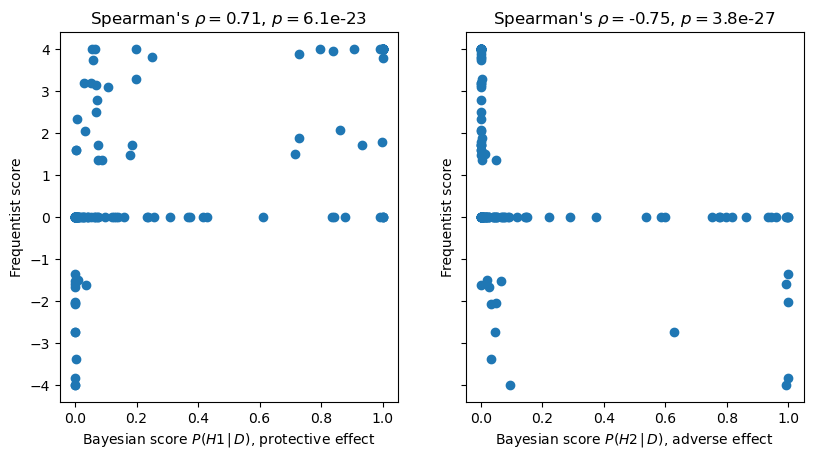

In [21]:
def my_scatter(results=results, y='Dunnett score', bayes_cols=['H1', 'H2']):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9.6, 4.8))
    for axi, H, effect in zip(ax, bayes_cols, ['protective', 'adverse']):
        axi.scatter(x=H, y=y, data=results)
        axi.set_xlabel(r'Bayesian score $P({} \, | \, D)$, {} effect'.format(H, effect))
        axi.set_ylabel('Frequentist score')
        v = spearmanr(results[[H, y]].dropna())
        axi.set_title(r"Spearman's $\rho=${:1.2}, $p=${:1.2}".format(v.statistic, v.pvalue))
    return((fig, ax))

fig, ax = my_scatter(results=results, y='Dunnett score', bayes_cols=['H1', 'H2'])
attila_utils.savefig(fig, 'posterior-vs-dunnettscore-spearman')

['named-figure/posterior-vs-dunnettscore-spearman-no-batch-corr.png',
 'named-figure/posterior-vs-dunnettscore-spearman-no-batch-corr.pdf']

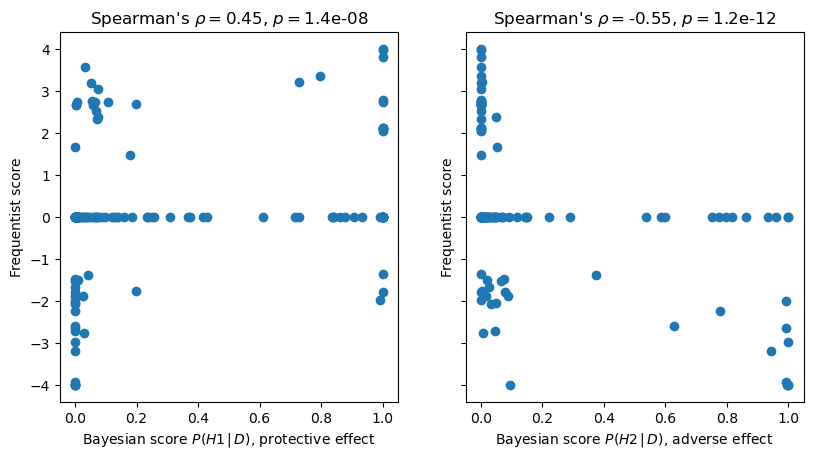

In [22]:
fig, ax = my_scatter(results=results, y='Dunnett score -batch', bayes_cols=['H1', 'H2'])
attila_utils.savefig(fig, 'posterior-vs-dunnettscore-spearman-no-batch-corr')

### Aggregation

In [23]:
P_TI = P.unstack(level=-1).groupby(level=1).mean().mean().unstack(level=0)
P_TI

,H1,H0,H2
TI1,0.249875,0.545708,0.204417
TI2,0.697542,0.136000,0.166458
TI3,0.813813,0.174813,0.011375
TI4,0.903062,0.095000,0.001937
TI5,0.999688,0.000312,0.000000
TI6,0.435479,0.390458,0.174063
TI7,0.983313,0.016687,0.000000
TI8,0.265583,0.519104,0.215312
TI9,0.960688,0.038500,0.000812
TI10,0.073437,0.693125,0.233437


In [24]:
BF_TI = pd.concat([2 * np.log((P_TI[H] / P_TI['H0'])).to_frame(col) for H, col in zip(['H1', 'H2'], ['BF1', 'BF2'])], axis=1)
def reshape_dunnett(s=Dunnett_s, col='Dunnett score'):
    val = s.unstack(level=-1).groupby(level=1).mean().mean().to_frame(col)
    return(val)
results_agg = pd.concat([BF_TI, reshape_dunnett(s=Dunnett_s, col='Dunnett score'), reshape_dunnett(s=Dunnett_s_nocorr, col='Dunnett score -batch')], axis=1)
results_agg = results_agg.sort_values('BF1', ascending=False)
results_agg['Bayes rank'] = np.arange(len(results_agg)) + 1
results_agg = results_agg.sort_values('Dunnett score', ascending=False)
results_agg['Dunnett rank'] = np.arange(len(results_agg)) + 1
results_agg = results_agg.sort_values('Dunnett score -batch', ascending=False)
results_agg['Dunnett rank -batch'] = np.arange(len(results_agg)) + 1
results_agg

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,BF1,BF2,Dunnett score,Dunnett score -batch,Bayes rank,Dunnett rank,Dunnett rank -batch
TI8,-1.340352,-1.760028,2.508332,1.503608,8,6,1
TI7,8.152534,-inf,3.426919,1.371007,2,2,2
TI5,16.141187,-inf,3.446022,1.363068,1,1,3
TI15,-4.025503,-6.737465,1.597507,1.359793,14,9,4
TI10,-4.489551,-2.176592,2.228792,1.345086,15,8,5
TI3,3.076032,-5.464592,3.000000,1.330934,6,5,6
TI9,6.433982,-7.716595,2.333333,0.919924,3,7,7
TI26,-2.236818,-4.075074,0.426492,0.434221,12,12,8
TI21,-1.592921,-3.669913,0.697503,0.206076,10,11,9
TI4,4.503830,-7.784957,3.000000,-0.115117,4,4,10


### Comparison after aggregation: TI scores

['named-figure/BF-vs-dunnettscore-spearman.png',
 'named-figure/BF-vs-dunnettscore-spearman.pdf']

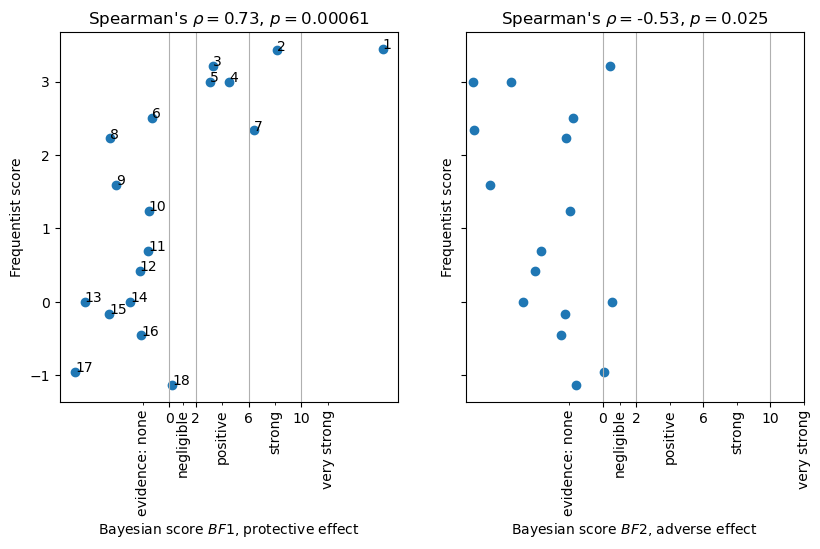

In [30]:
def my_scatter_BF(results=results_agg, y='Dunnett score', rank_col='Dunnett rank', bayes_cols=['BF1', 'BF2']):
    fig, ax = my_scatter(results=results, y=y, bayes_cols=bayes_cols)
    for axi, BF, effect in zip(ax, ['BF1', 'BF2'], ['protective', 'adverse']):
        xticks_major = [0, 2, 6, 10]
        xticks_minor = [-2, 1, 4, 8, 12]
        axi.set_xticks(xticks_major, minor=False)
        axi.set_xticks(xticks_minor, minor=True)
        xticklabels_minor = ['evidence: none', 'negligible', 'positive', 'strong', 'very strong']
        axi.set_xticklabels(xticklabels_minor, minor=True, rotation=90)
        axi.grid(axis='x')
        axi.set_xlabel(r'Bayesian score ${}$, {} effect'.format(BF, effect))
    axi = ax[0]
    for i in range(len(results)):
        row = results.iloc[i]
        axi.text(x=row.loc['BF1'], y=row.loc[y], s=str(np.int64(row.loc[rank_col])))
    return((fig, ax))

fig, ax = my_scatter_BF(results=results_agg, y='Dunnett score', bayes_cols=['BF1', 'BF2'])
attila_utils.savefig(fig, 'BF-vs-dunnettscore-spearman')

['named-figure/BF-vs-dunnettscore-spearman-no-batch-corr.png',
 'named-figure/BF-vs-dunnettscore-spearman-no-batch-corr.pdf']

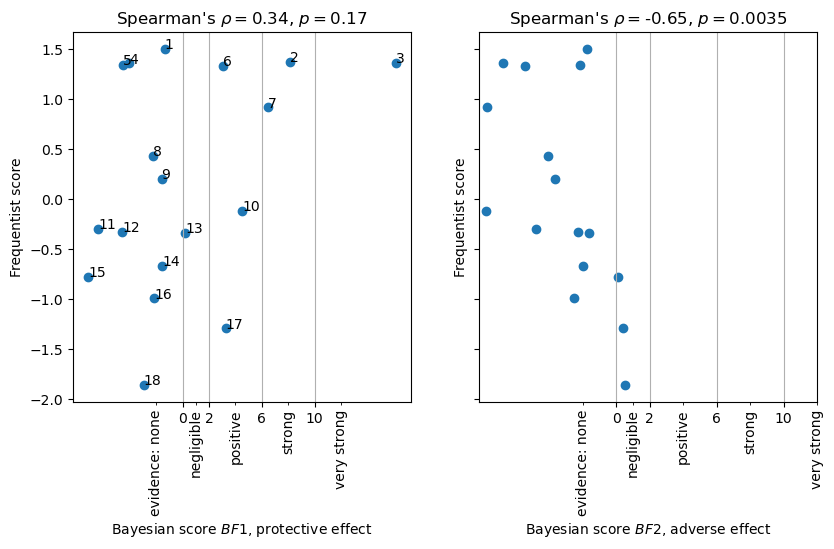

In [31]:
fig, ax = my_scatter_BF(results=results_agg, y='Dunnett score -batch', rank_col='Dunnett rank -batch', bayes_cols=['BF1', 'BF2'])
attila_utils.savefig(fig, 'BF-vs-dunnettscore-spearman-no-batch-corr')

In [20]:
%connect_info

{
  "shell_port": 53697,
  "iopub_port": 53698,
  "stdin_port": 53699,
  "control_port": 53701,
  "hb_port": 53700,
  "ip": "127.0.0.1",
  "key": "32d8d8d1-89bf7918f0f31de834fb5f3c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-03-04-cell-bayes-vs-frequentist/2024-03-04-cell-bayes-vs-frequentist.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-95dc5acc-8050-48f5-aa23-86fbdf7ce7a2.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
